# Case Study
### Stephanie Beyer Diaz
This Notebook contains Python code for reading, cleaning and preprocessing data for a <a href='https://www.kaggle.com/c/mbd2019-in-class-competition-bank-mkt'>Kaggle in-class competition</a>, using a banking telemarketing prediction dataset.

### Importing necessary packages

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import woeBinningPandas
import ast

from sklearn                 import preprocessing
from sklearn.utils           import resample
from sklearn.metrics         import f1_score, recall_score, roc_curve, roc_auc_score, \
                                    auc, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, PredefinedSplit
from sklearn.linear_model    import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn.tree            import DecisionTreeClassifier
from sklearn.neighbors       import KNeighborsClassifier
from xgboost                 import XGBClassifier
from imblearn.pipeline       import Pipeline
from imblearn.over_sampling  import SMOTE
from xverse.transformer      import MonotonicBinning, WOE
from sklearn.compose         import ColumnTransformer

#Setting options for visualizing dataframes and model iterations
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

### Reading in Data
In this step, data is loaded from the Excel files provided, with the test set being set apart for later and the train set being split into train, validation, and test. 

In [100]:
#Reading data
test_holdout = pd.read_csv('bank_mkt_test.csv')
train_full = pd.read_csv('bank_mkt_train.csv')
train_full.head()

,client_id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,2,29,housemaid,single,high.school,no,no,no,telephone,may,mon,3,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,0
1,3,39,unemployed,married,basic.9y,unknown,yes,no,telephone,jun,fri,6,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
2,4,49,blue-collar,married,basic.6y,unknown,no,no,cellular,nov,tue,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,0
3,5,32,self-employed,single,university.degree,no,yes,no,cellular,may,mon,3,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,0
4,6,29,admin.,single,high.school,unknown,yes,no,cellular,jul,fri,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0


In [101]:
#cleaning string values for dummy and binning later
train_full['job'] = train_full['job'].str.replace('-', '_')
train_full['education'] = train_full['education'].str.replace('-', '_')

test_holdout['job'] = test_holdout['job'].str.replace('-', '_')
test_holdout['education'] = test_holdout['education'].str.replace('-', '_')

Text(0.5, 1.0, 'Target Variable Distribution')

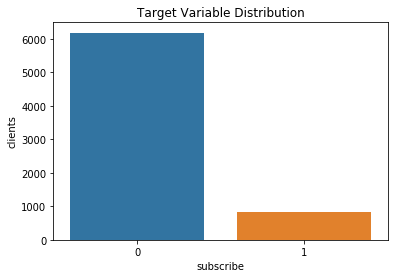

In [102]:
#Checking target variable distribution: unbalanced targets
plot = train_full[['client_id','subscribe']].groupby('subscribe').count()
plot.reset_index(inplace=True,drop=False)
plot.columns= ['subscribe','clients']

sns.barplot(x='subscribe',y='clients',data=plot).set_title("Target Variable Distribution")

### Missing Values

In [103]:
#for categorical variables, 'unknown' was considered a missing value
train_full['default'].value_counts()

no         5571
unknown    1429
Name: default, dtype: int64

In [104]:
train_full['education'].value_counts()

university.degree      2103
high.school            1638
basic.9y               993 
professional.course    886 
basic.4y               716 
basic.6y               362 
unknown                295 
illiterate             7   
Name: education, dtype: int64

In [105]:
#missing values: status 'unknown' < 5% for loan, housing, education and marital columns, dropping rows
#unknown value for job will be solved with binning
# train_full['job'].value_counts()
train_full = train_full[~(train_full['marital']=='unknown')]
train_full = train_full[~(train_full['loan']=='unknown')]
train_full = train_full[~(train_full['housing']=='unknown')]
train_full = train_full[~(train_full['education']=='unknown')]

### Splitting datasets

In [106]:
#creating variables for sample
rows = train_full.shape[0]
values = list(train_full.index)

#creating random sample
random.seed(7)
sample_rows = random.sample(values,round(rows*0.6)) 

#splitting train into validation set
train = train_full.iloc[train_full.index.isin(sample_rows),:]  # Train 60%
valid_test = train_full.iloc[~train_full.index.isin(sample_rows),:]  # Valid + Test 40%

In [107]:
#creating variables for sample
rows_v = valid_test.shape[0]
values_v = list(valid_test.index)

#creating random sample
random.seed(7)
sample_rows_v = random.sample(values_v,round(rows_v*0.5)) 

#further splitting validation into validation and test set
valid = valid_test.iloc[valid_test.index.isin(sample_rows_v),:]  # Valid 20%
test = valid_test.iloc[~valid_test.index.isin(sample_rows_v),:]  # Test 20%

In [108]:
print("train:")
print(train[["subscribe","client_id"]].groupby("subscribe").count())
print("")
print("valid:")
print(valid[["subscribe","client_id"]].groupby("subscribe").count())
print("")
print("test:")
print(test[["subscribe","client_id"]].groupby("subscribe").count())

train:
           client_id
subscribe           
0          3441     
1          479      

valid:
           client_id
subscribe           
0          1155     
1          152      

test:
           client_id
subscribe           
0          1169     
1          138      


### Binning Variables

In [109]:
#Checking IV for all variables

columns = list(set(train.columns).difference(['subscribe','client_id']))

def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

iv_df = pd.DataFrame(columns=['variable','iv'])

for col in columns:
    df, iv = calculate_woe_iv(train, col, 'subscribe')
    iv_df = pd.concat((iv_df,pd.DataFrame([[col,iv]],columns=['variable','iv'])))

In [110]:
iv_df.sort_values('iv',ascending=False)

,variable,iv
0,euribor3m,1.415811
0,cons.conf.idx,1.381723
0,cons.price.idx,1.381723
0,nr.employed,1.182948
0,emp.var.rate,1.081069
0,month,0.584570
0,pdays,0.559403
0,poutcome,0.551891
0,age,0.410025
0,previous,0.338439


In [111]:
#np.percentile(train['age'],[20,40,60,80])

#creating bins for age, based on percentiles
train['age_dist'] = pd.qcut(train['age'], 5, 
                            labels=['Age_lt_31', 'Age_31_to_36', 'Age_36_to_41', 'Age_41_to_50', 'Age_gt_50'])

valid['age_dist'] = pd.qcut(valid['age'], 5, 
                            labels=['Age_lt_31', 'Age_31_to_36', 'Age_36_to_41', 'Age_41_to_50', 'Age_gt_50'])

test['age_dist'] = pd.qcut(test['age'], 5, 
                            labels=['Age_lt_31', 'Age_31_to_36', 'Age_36_to_41', 'Age_41_to_50', 'Age_gt_50'])

test_holdout['age_dist'] = pd.qcut(test_holdout['age'], 5, 
                            labels=['Age_lt_31', 'Age_31_to_36', 'Age_36_to_41', 'Age_41_to_50', 'Age_gt_50'])

In [112]:
#binning job
binning = woeBinningPandas.woe_binning(train, "subscribe", "job", 0.05, 0, 0.1, 50, "bad")
binning

#renaming binning columns for merging
binning.columns = ['job_binned','job','woe', 'iv_total_final', 'good', 'bad',
       'col_perc_a', 'col_perc_b', 'iv_bins']
binning = binning[['job_binned','job']]

train = train.merge(binning, how='left', on='job')
train.head()

valid = valid.merge(binning, how='left', on='job')
test = test.merge(binning, how='left', on='job')

test_holdout = test_holdout.merge(binning, how='left', on='job')

In [113]:
#binning age
# binningage = woeBinningPandas.woe_binning(train, "subscribe", "age", 0.05, 0, 0.1, 50, "good")

# #binning age thresholds
# agebin1 = binningage["upper_cutpoints_final_dfrm"][0]
# agebin2 = binningage["upper_cutpoints_final_dfrm"][1]
# agebin3 = binningage["upper_cutpoints_final_dfrm"][2]

# binningage

In [114]:
#creating column with age binning, this was dropped because binning by percentile results in higher fisher score
# def bins(df):
#     df['age_binned'] = 'other'
#     df.loc[df['age'] <=agebin1, 'age_binned'] = '_inf_29' #(-inf, 26.0]
#     df.loc[(df['age'] >agebin1) & (df['age'] <= agebin2), 'age_binned'] = '_29_40' #(26.0, 36.0]
#     df.loc[(df['age'] >agebin2) & (df['age'] <= agebin3), 'age_binned'] = '40_50' #(36.0, 55.0]
#     df.loc[(df['age'] >agebin3), 'age_binned'] = '50_inf' #(55.0, inf]
    
#     return df

# train = bins(train)
# valid = bins(valid)
# test = bins(test)
# test_holdout = bins(test_holdout)

### Dummy variables

In [115]:
#age above or below mean
age_mean = train["age"].mean()

train["age_mean"] = (train["age"]>age_mean)*1
valid["age_mean"] = (valid["age"]>age_mean)*1
test["age_mean"] = (test["age"]>age_mean)*1
test_holdout["age_mean"] = (test_holdout["age"]>age_mean)*1

In [116]:
#contacted binary variable
train['contacted'] = (train["pdays"]!=999)*1
valid['contacted'] = (valid["pdays"]!=999)*1
test['contacted'] = (test["pdays"]!=999)*1
test_holdout['contacted'] = (test_holdout["pdays"]!=999)*1

In [117]:
#seasons binary variable
train['summer'] = (train["month"].isin(['jun','jul','aug']))*1
valid['summer'] = (valid["month"].isin(['jun','jul','aug']))*1
test['summer'] = (test["month"].isin(['jun','jul','aug']))*1
test_holdout['summer'] = (test_holdout["month"].isin(['jun','jul','aug']))*1

train['winter'] = (train["month"].isin(['dec','jan','feb']))*1
valid['winter'] = (valid["month"].isin(['dec','jan','feb']))*1
test['winter'] = (test["month"].isin(['dec','jan','feb']))*1
test_holdout['winter'] = (test_holdout["month"].isin(['dec','jan','feb']))*1

train['spring'] = (train["month"].isin(['mar','apr','may']))*1
valid['spring'] = (valid["month"].isin(['mar','apr','may']))*1
test['spring'] = (test["month"].isin(['mar','apr','may']))*1
test_holdout['spring'] = (test_holdout["month"].isin(['mar','apr','may']))*1

# n-one dummy variables
# df['autumn'] = (df["month"].isin(['sep','oct','nov']))*1 

In [118]:
#campaign multiple contacts=1, single contact=0
#as it includes last contact, a client with previous=1 and n_campaign=0 means no contact in current campaign
train["n_campaign"] = (train["campaign"]!=1)*1
valid["n_campaign"] = (valid["campaign"]!=1)*1
test["n_campaign"] = (test["campaign"]!=1)*1
test_holdout["n_campaign"] = (test_holdout["campaign"]!=1)*1

In [119]:
#dummy variable list
dummies = ["job_binned","marital","education","default","housing",
           "loan","contact","day_of_week","poutcome",'age_dist'] #"age_binned","month","job","campaign"

In [120]:
train_dummies = pd.get_dummies(train[dummies],drop_first=True)
valid_dummies = pd.get_dummies(valid[dummies],drop_first=True)
test_dummies = pd.get_dummies(test[dummies],drop_first=True)
testh_dummies = pd.get_dummies(test_holdout[dummies],drop_first=True)

In [121]:
#adding missing dummy column to holdout set
val = train_dummies.columns[~train_dummies.columns.isin(testh_dummies.columns)][0]
testh_dummies[val] = 0

In [122]:
#adding dummy variables to datasets
keep_cols = list(set(train.columns).difference(set(dummies)))
keep_cols2 = list(set(train.columns).difference(set(dummies))) 
keep_cols2.remove('subscribe')

train = pd.concat((train[keep_cols], train_dummies), axis=1)
valid = pd.concat((valid[keep_cols], valid_dummies), axis=1)
test = pd.concat((test[keep_cols], test_dummies), axis=1)
test_holdout = pd.concat((test_holdout[keep_cols2], testh_dummies), axis=1)

In [123]:
#dropping original values from datasets to just leave dummies
train.drop(["month","job","age","pdays",'campaign'],axis=1, inplace=True)
valid.drop(["month","job","age","pdays",'campaign'],axis=1, inplace=True)
test.drop(["month","job","age","pdays",'campaign'],axis=1, inplace=True)
test_holdout.drop(["month","job","age","pdays",'campaign'],axis=1, inplace=True)

In [124]:
#basetables:
train.to_csv('train.csv')
valid.to_csv('valid.csv')
test.to_csv('test.csv')
test_holdout.to_csv('test_holdout.csv')

In [125]:
#columns for standardizing data
scaled_cols = ['cons.conf.idx','emp.var.rate','nr.employed','cons.price.idx','euribor3m']

#Creating the Scaler object
scaler = preprocessing.StandardScaler()

In [126]:
test.shape

(1307, 38)

In [127]:
train.columns

Index(['cons.price.idx', 'subscribe', 'summer', 'euribor3m', 'n_campaign',
       'cons.conf.idx', 'contacted', 'winter', 'spring', 'emp.var.rate',
       'age_mean', 'client_id', 'nr.employed', 'previous',
       'job_binned_services + blue_collar',
       'job_binned_technician + misc. level pos. + management + admin.',
       'marital_married', 'marital_single', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'default_unknown', 'housing_yes', 'loan_yes', 'contact_telephone',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success',
       'age_dist_Age_31_to_36', 'age_dist_Age_36_to_41',
       'age_dist_Age_41_to_50', 'age_dist_Age_gt_50'],
      dtype='object')

In [128]:
# no missing values
# train.isna().sum()
# valid.isna().sum()
# test.isna().sum()
# test_holdout.isna().sum()

### Feature Selection & Model Building
Fisher score was used to select features. Logistic model parameters were tuned. Confusion matrix, AUC and accuracy scores were looked at to compare different logistic models. Undersampling was found to achieve the best results.

In [129]:
#Fisher score: feature selection
def fisherscore(X, y):
    """
    This function calculate the Fisher score of all variables of the basetable.
    
    Input:
        
        X: [Pandas Dataframe] the independent variables basetable for modeling.
        y: [Pandas Series] the target variable.
        
    Output:
        
        Pandas Dataframe contains the Fisher score for each independent varibales.
    
    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). 
    New insights into churn prediction in the telecommunication sector: 
            A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the list of independent variables
    vars_list = list(X.columns)
    vars_list.remove('client_id')
    
    # Get the unique values of dependent/target variable
    # Should be 2 classes [0, 1]
    target_unique = y.unique()
  
    iv_fisherscore = []
    
    for v in vars_list:
        fs = np.abs(np.mean(X.loc[y == target_unique[0], v]) - \
                    np.mean(X.loc[y == target_unique[1], v])) / \
             np.sqrt(np.var(X.loc[y == target_unique[0], v]) + \
                     np.var(X.loc[y == target_unique[1], v]))
        iv_fisherscore.append(fs)
        
    return pd.DataFrame(iv_fisherscore, index=vars_list, columns=['fisher_score'])

#code snippet provided by Professor Minh Phan in Financial Programming course

In [130]:
#Applying Fisher Score
x = list(train.columns)
x.remove('subscribe')
y = 'subscribe'

fs = fisherscore(train[x], train[y])
fs = fs.sort_values(by='fisher_score', ascending=False)[1:]

In [131]:
#Extracting top 20 variables
fs[:20]

,fisher_score
euribor3m,0.705980
emp.var.rate,0.683008
contacted,0.461237
poutcome_success,0.431598
previous,0.377236
poutcome_nonexistent,0.359728
contact_telephone,0.350622
cons.price.idx,0.282555
default_unknown,0.230915
job_binned_services + blue_collar,0.203114


In [132]:
# Undersampling train set (did not improve results)

df_majority = train[train["subscribe"]==0]
df_majority.reset_index(drop=True,inplace=True)

df_minority = train[train["subscribe"]==1]
df_minority.reset_index(drop=True,inplace=True)

downsampled = resample(df_majority, 
                       replace=True, # sample with replacement
                       n_samples=len(df_minority), # match number in minority class (0)
                       random_state=27)

downsampled.reset_index(drop=True,inplace=True)

downsampled = pd.concat([df_minority, downsampled])

In [133]:
# Oversampling train set, using different technique than SMOTE
oversampled = resample(df_minority, 
                       replace=True, # sample with replacement
                       n_samples=len(df_majority), # match number in majority class (1)
                       random_state=27)

oversampled.reset_index(drop=True,inplace=True)

oversampled = pd.concat([df_majority, oversampled])

In [134]:
print(downsampled.shape)
print(oversampled.shape)

(958, 38)
(6882, 38)


In [135]:
#creating predefined split with previously split data for gridsearch

train_valid = pd.concat((train,valid),axis=0)

train_valid["fold"] = train_valid.client_id.isin(train.client_id)*-1

fold = np.array(train_valid["fold"])

ps = PredefinedSplit(test_fold=fold)

In [136]:
#train_valid[fs[:f].index.values]
train_valid.shape

(5227, 39)

logistic
        pred:1  pred:0
true:1  104     48    
true:0  327     828   


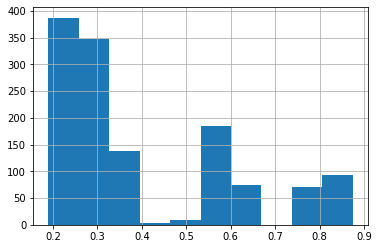

randomForest
        pred:1  pred:0
true:1  75      77    
true:0  150     1005  


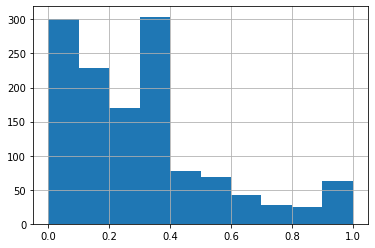

gaussiannb
        pred:1  pred:0
true:1  104     48    
true:0  327     828   


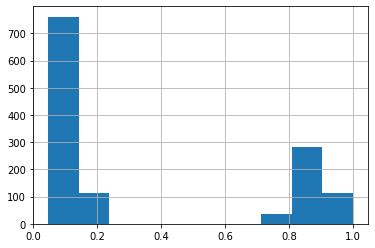

ada
        pred:1  pred:0
true:1  104     48    
true:0  327     828   


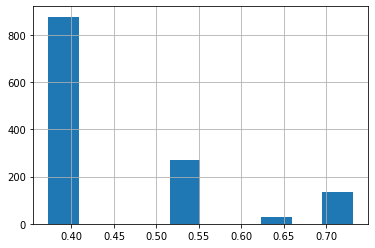

gbc
        pred:1  pred:0
true:1  98      54    
true:0  213     942   


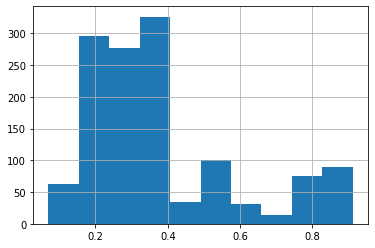

knn
        pred:1  pred:0
true:1  97      55    
true:0  191     964   


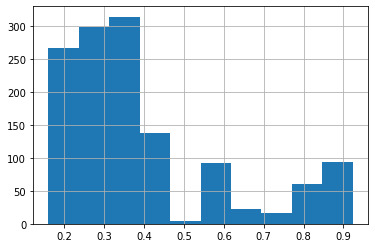

dtree
        pred:1  pred:0
true:1  88      64    
true:0  170     985   


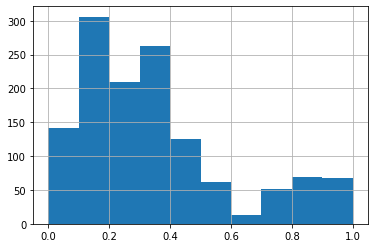

In [137]:
outcome = pd.DataFrame() #empty dataframe to save performance results
f = 20 #number of fisher variables

#initializing classification models
gaussiannb         = GaussianNB()
logistic           = LogisticRegression()
randomForest       = RandomForestClassifier()
ada                = AdaBoostClassifier()
xg                 = XGBClassifier()
gbc                = GradientBoostingClassifier() 
dtree              = DecisionTreeClassifier()
knn                = KNeighborsClassifier()

#saving models in dictionary to iterate
models = {
         "logistic"       :logistic,
         "randomForest"   :randomForest,
         "gaussiannb"     :gaussiannb,
         #"xgboost"        :xg,
         "ada"            :ada,
         "gbc"            :gbc,
         'knn'            :knn,
         'dtree'          :dtree
}

#grid values in dictionary to iterate
grid_values = {
    "logistic":{"model__solver":["lbfgs", "newton-cg", "sag", "saga"], 'model__penalty': ['l2', None],'model__C':[1,2,3],
                "model__max_iter":[10,25,50], "model__class_weight":[None, "balanced"]},
    
    "randomForest":{"model__n_estimators": [50,100,300], "model__criterion": ['gini','entropy'],"model__bootstrap": [True,False],
                    "model__oob_score": [True,False], "model__class_weight": ["balanced", "balanced_subsample", None],
                    "model__max_features":["auto","sqrt", "log2"],"model__min_samples_split": [1,2,3],
                   "model__min_samples_leaf":[1,2,3]},
    
    "gaussiannb":{"model__var_smoothing": [1e-9,(1e-9)/5,(1e-9)/2]},
    
    "xgboost":{"model__booster":['gbtree','dart'],'model__max_depth':[6,50,500],'model__min_child_weight ':[1,5,100],
              'model__n_estimators':[100,500,1000,1500],'model__learning_rate':[0.001,0.01,1]},
    
    "ada":{"model__n_estimators":[1,2,3],"model__algorithm":["SAMME", "SAMME.R"]},
    
    "gbc":{'model__loss':['deviance','exponential'],'model__n_estimators':[50,100,150,200]},
    
    'knn':{'model__n_neighbors':[8,100,300],'model__weights':['uniform','distance'],
           'model__algorithm':['ball_tree','kd_tree','‘brute','auto']},
    
    'dtree':{'model__splitter':['random','best'],"model__criterion": ['gini','entropy'],
             'model__max_features':['auto', 'sqrt', 'log2'],'model__min_samples_split':[2,10,20,100]}
}

#columns to be scaled (intersection of previously selected "scaled_cols" and fisher variables)
scaled_fisher = list(set(scaled_cols).intersection(set(fs[:f].index.values)))

transfo_quanti = Pipeline(steps=[('standard', preprocessing.StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('quanti', transfo_quanti , scaled_fisher)])

#iterating through models
for model in models:
    
    pipe                = Pipeline(steps=[('scaling', preprocessor),('sampling', SMOTE()),('model', models[model])])
    
    search_grid         = grid_values[model]
    
    grid_clf_acc        = GridSearchCV(pipe, param_grid = search_grid, cv=3, n_jobs=-1, scoring = 'roc_auc', refit=True)

    #grid_clf_acc.fit(train_valid[fs[:f].index.values], train_valid[y])
    grid_clf_acc.fit(train[fs[:f].index.values], train[y])
    
#     pipe.set_params(**grid_clf_acc.best_params_)
#     pipe.fit(train_valid[fs[:f].index.values], train_valid[y])

    predictions         = grid_clf_acc.predict(valid[fs[:f].index.values])
    predictions_t       = grid_clf_acc.predict(test[fs[:f].index.values])
    
    probabilities       = pd.DataFrame(grid_clf_acc.predict_proba(valid[fs[:f].index.values]))[1]
    probabilities_t     = pd.DataFrame(grid_clf_acc.predict_proba(valid[fs[:f].index.values]))[1]

    auc                 = roc_auc_score(np.array(valid[y]),np.array(probabilities))
    auc_t               = roc_auc_score(np.array(test[y]),np.array(probabilities_t))
    
    cv_score            = cross_val_score(grid_clf_acc, valid[fs[:f].index.values], valid[y], cv=10, scoring='roc_auc')
    
    #confusion matrix
    cmtx                = pd.DataFrame(confusion_matrix(valid[y], predictions, labels=[1, 0]), 
                            index=['true:1', 'true:0'], 
                            columns=['pred:1', 'pred:0'])
    
    valid_report        = classification_report(valid[y], predictions, output_dict=True)
    
    prec                = valid_report.get('1').get('precision')
    rec_                = valid_report.get('1').get('recall')
    
    
    cmtx_t              = pd.DataFrame(confusion_matrix(test[y], predictions, labels=[1, 0]), 
                            index=['true:1', 'true:0'], 
                            columns=['pred:1', 'pred:0'])
    
    test_report         = classification_report(test[y], predictions_t, output_dict=True)
    
    prec_t              = test_report.get('1').get('precision')
    rec_t               = test_report.get('1').get('recall')
    
    performances        = {'Model':model,"AUC":np.mean(cv_score),"AUC_test":auc,
                           'params':grid_clf_acc.best_params_,'Precision':prec,'Precision_test':prec_t,
                          'Recall':rec_,'Recall_test':rec_t} 
    
    #saving results
    outcome             = pd.concat((outcome,pd.DataFrame([performances])))
    
    #additional information to select voting classifiers
    print(model)
    print(cmtx)
    
    probabilities.hist()
    plt.show()

In [145]:
outcome.sort_values(by='AUC_test', ascending=False, inplace=True)
outcome

,Model,AUC,AUC_test,params,Precision,Precision_test,Recall,Recall_test
0,knn,0.763762,0.784834,"{'model__algorithm': 'ball_tree', 'model__n_neighbors': 300, 'model__weights': 'uniform'}",0.336806,0.301754,0.638158,0.623188
0,gbc,0.761915,0.770281,"{'model__loss': 'exponential', 'model__n_estimators': 50}",0.315113,0.292605,0.644737,0.659420
0,dtree,0.762947,0.752159,"{'model__criterion': 'gini', 'model__max_features': 'auto', 'model__min_samples_split': 100, 'model__splitter': 'random'}",0.341085,0.339921,0.578947,0.623188
0,ada,0.725109,0.740949,"{'model__algorithm': 'SAMME', 'model__n_estimators': 3}",0.241299,0.227166,0.684211,0.702899
0,randomForest,0.751625,0.736224,"{'model__bootstrap': True, 'model__class_weight': None, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 300, 'model__oob_score': True}",0.333333,0.340807,0.493421,0.550725
0,logistic,0.715735,0.726361,"{'model__C': 3, 'model__class_weight': 'balanced', 'model__max_iter': 25, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}",0.241299,0.227166,0.684211,0.702899
0,gaussiannb,0.720572,0.716957,{'model__var_smoothing': 5e-10},0.241299,0.227166,0.684211,0.702899


In [146]:
outcome2 = outcome.copy()
outcome2.reset_index(inplace=True,drop=True)
for i in range(0,outcome2.shape[1]-1):
    outcome2.loc[i,'params'] = [ast.literal_eval(str(outcome2.loc[i,'params']).replace('model__',''))]

outcome2
#logistic.set_params(**outcome2.loc[outcome2['Model']=='logistic','params'][0])

,Model,AUC,AUC_test,params,Precision,Precision_test,Recall,Recall_test
0,knn,0.763762,0.784834,"{'algorithm': 'ball_tree', 'n_neighbors': 300, 'weights': 'uniform'}",0.336806,0.301754,0.638158,0.623188
1,gbc,0.761915,0.770281,"{'loss': 'exponential', 'n_estimators': 50}",0.315113,0.292605,0.644737,0.659420
2,dtree,0.762947,0.752159,"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'splitter': 'random'}",0.341085,0.339921,0.578947,0.623188
3,ada,0.725109,0.740949,"{'algorithm': 'SAMME', 'n_estimators': 3}",0.241299,0.227166,0.684211,0.702899
4,randomForest,0.751625,0.736224,"{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300, 'oob_score': True}",0.333333,0.340807,0.493421,0.550725
5,logistic,0.715735,0.726361,"{'C': 3, 'class_weight': 'balanced', 'max_iter': 25, 'penalty': 'l2', 'solver': 'lbfgs'}",0.241299,0.227166,0.684211,0.702899
6,gaussiannb,0.720572,0.716957,{'var_smoothing': 5e-10},0.241299,0.227166,0.684211,0.702899


In [168]:
knn.set_params(**list(outcome2.loc[outcome2['Model']=='knn','params'])[0])
gbc.set_params(**list(outcome2.loc[outcome2['Model']=='gbc','params'])[0])
dtree.set_params(**list(outcome2.loc[outcome2['Model']=='dtree','params'])[0])
ada.set_params(**list(outcome2.loc[outcome2['Model']=='ada','params'])[0])
randomForest.set_params(**list(outcome2.loc[outcome2['Model']=='randomForest','params'])[0])
logistic.set_params(**list(outcome2.loc[outcome2['Model']=='logistic','params'])[0])
gaussiannb.set_params(**list(outcome2.loc[outcome2['Model']=='gaussiannb','params'])[0])

GaussianNB(priors=None, var_smoothing=5e-10)

In [174]:
vote_outcome = pd.DataFrame()
vote_list = []
auc_comp = 0

for model in outcome2['Model']: #starting from highest AUC
    
    modeltuple = tuple((model,models[model]))
    
    vote_list.append(modeltuple)
    
    eclf = VotingClassifier(estimators=vote_list, voting='soft')
    
    eclf.fit(train[fs[:f].index.values], train[y])
    
    predictions         = eclf.predict(valid[fs[:f].index.values])
    predictions_t       = eclf.predict(test[fs[:f].index.values])
    
    probabilities       = pd.DataFrame(eclf.predict_proba(valid[fs[:f].index.values]))[1]
    probabilities_t     = pd.DataFrame(eclf.predict_proba(valid[fs[:f].index.values]))[1]

    auc                 = roc_auc_score(np.array(valid[y]),np.array(probabilities))
    auc_t               = roc_auc_score(np.array(test[y]),np.array(probabilities_t))

    if auc>auc_comp:
        auc_comp = auc
    else:
        vote_list.remove(modeltuple)
        
    cv_score            = cross_val_score(grid_clf_acc, valid[fs[:f].index.values], valid[y], cv=10, scoring='roc_auc')
    
    performances        = {'Models':[x[0] for x in vote_list],"AUC":np.mean(cv_score),"AUC_test":auc} 
    
    #saving results
    vote_outcome             = pd.concat((vote_outcome,pd.DataFrame([performances])))

In [175]:
vote_outcome

,Models,AUC,AUC_test
0,[knn],0.758834,0.766789
0,"[knn, gbc]",0.758481,0.770711
0,"[knn, gbc]",0.777066,0.763856
0,"[knn, gbc]",0.765408,0.769782
0,"[knn, gbc, randomForest]",0.767638,0.771255
0,"[knn, gbc, randomForest, logistic]",0.755372,0.775111
0,"[knn, gbc, randomForest, logistic]",0.780224,0.767114


In [176]:
full = pd.concat((train,valid,test),axis=0)

In [183]:
final_vote = [logistic, randomForest, knn, gbc]
vote_list = []

for v in final_vote:
    modeltuple = tuple((str(v)[:3],v))
    vote_list.append(modeltuple)

In [186]:
eclf = VotingClassifier(estimators=vote_list, voting='soft')
eclf = eclf.fit(full[fs[:f].index.values], full[y])
probabilities = pd.DataFrame(eclf.predict_proba(test_holdout[fs[:f].index.values]))[1]

In [189]:
submission = pd.concat((test_holdout.client_id,probabilities),axis=1)

submission.columns=['client_id','subscribe']
submission.head()
submission.to_csv('submission_final.csv',index=False)